## Verificación de locutores

Dado un segmento de voz Y, y un locutor hipotético S, la tarea de la verificación de locutores es determinar si Y fue dicho por S.  
Supondremos que Y siempre tiene locuciones de un solo locutor.

In [1]:
from python_speech_features import mfcc 
from python_speech_features import logfbank
from python_speech_features import base
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

In [2]:
def mfcc_wav(file):
    (rate,sig) = wav.read(file)
    mfcc_feat = mfcc(sig,rate,nfft=512,appendEnergy=True)
    return mfcc_feat

In [3]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [4]:
WINDOW_SIZE = 20

def preprocess(file_wav, matrix):
    mundo_size = file_wav.shape[0] - WINDOW_SIZE + 1
    mundo = np.array([file_wav[i:i+WINDOW_SIZE].reshape(1,WINDOW_SIZE*file_wav.shape[1])[0] for i in range(mundo_size)])
    mundo_labels = np.array(matrix * mundo.shape[0])
    return mundo_size, mundo, mundo_labels

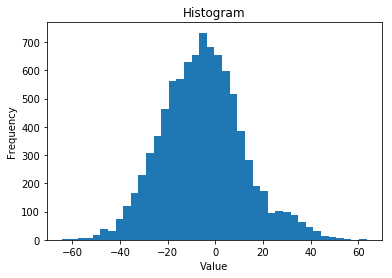

In [5]:
mfcc_feat = mfcc_wav("./mundo.wav")
plt.hist(mfcc_feat.T[5], bins=40)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

#### Preprocesamiento Train

In [6]:
mfcc_feat = mfcc_wav("./mundo.wav")
mundo_size, mundo, mundo_labels = preprocess(mfcc_feat, [[0,1]])

In [7]:
mfcc_feat = mfcc_wav("./homero.wav")
homero_size, homero, homero_labels = preprocess(mfcc_feat, [[1,0]])

In [8]:
train_labels = np.vstack([homero_labels,mundo_labels])
train_set = np.vstack([homero,mundo])

#### Preprocesamiento Test

In [9]:
mfcc_feat = mfcc_wav("./mundo_test_1.wav")
mundo_size, mundo, mundo_labels = preprocess(mfcc_feat, [[0,1]])

In [10]:
mfcc_feat = mfcc_wav("./homero_test.wav")
homero_size, homero, homero_labels = preprocess(mfcc_feat, [[1,0]])

In [11]:
test_labels = np.vstack([homero_labels,mundo_labels])
test_set = np.vstack([homero,mundo])

In [12]:
mfcc_feat = mfcc_wav("./mundo_test_2.wav")
mundo_size, mundo, mundo_labels = preprocess(mfcc_feat, [[0,1]])

In [13]:
mfcc_feat = mfcc_wav("./homero_test_2.wav")
homero_size, homero, homero_labels = preprocess(mfcc_feat, [[1,0]])

In [14]:
test2_labels = np.vstack([homero_labels,mundo_labels])
test2_set = np.vstack([homero,mundo])

#### TRAINING

In [15]:
import tensorflow as tf
import shutil
from time import time
from tensorboard import summary as summary_lib

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
logs_path="log_dir"
logs_path1="log_dir/train"
logs_path2="log_dir/test"
# Parameters
learning_rate = 0.01
training_epochs = 42
batch_size = 256
display_step = 1
hidden_units=50

# Network Parameters
n_input =  train_set.shape[1] 
n_classes = 2 # classes

In [17]:
import tensorflow as tf
import shutil
from tensorboard import summary as summary_lib
shutil.rmtree(logs_path)

logs_path="log_dir"
logs_path1="log_dir/train"
logs_path2="log_dir/test"
# Parameters
learning_rate = 0.01
training_epochs = 40
batch_size = 256
display_step = 1
hidden_units=50

# Network Parameters
n_input =  train_set.shape[1] 
n_classes = 2 # classes

with tf.name_scope("inputs"):
    # tf Graph input
    X = tf.placeholder("float", [None, n_input],name="X")
with tf.name_scope("labels"):
    Y = tf.placeholder("float", [None, n_classes],name="Y")

# Construct model
with tf.name_scope('Capa1'):
    # Model
    weights1= tf.Variable(tf.random_normal([n_input, hidden_units]),name="weights1")
    bias1= tf.Variable(tf.random_normal([hidden_units]),name="bias1")
    act1= tf.nn.sigmoid(tf.matmul(X,weights1)+bias1, name="activacion_1")

with tf.name_scope('Capa2'):
    # Model
    weights2= tf.Variable(tf.random_normal([hidden_units, n_classes]),name="weights2")
    bias2= tf.Variable(tf.random_normal([n_classes]),name="bias2")
    logits= tf.matmul(act1,weights2)+bias2

with tf.name_scope('Loss'):
# Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=logits, labels=Y),name="costo")
    
with tf.name_scope('BGD'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,name="optimizador")
    train_op = optimizer.minimize(loss_op)
    
with tf.name_scope('Accuracy'):
    # Accuracy
    #pred = tf.nn.softmax(logits) # Softmax
    acc_op = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    acc_op = tf.reduce_mean(tf.cast(acc_op, tf.float32),name="acc_red_mean")
    
# Initializing the variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss_op)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", acc_op)
# Merge all summaries into a single op
tf.summary.histogram('histogram', weights1)
merged_summary_op = tf.summary.merge_all()

In [19]:
t0=time()
with tf.Session() as sess:
    sess.run(init)
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path1, graph=sess.graph)
    summary_writer_test = tf.summary.FileWriter(logs_path2, graph=sess.graph)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(train_set.shape[0]/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = next_batch(batch_size,train_set,train_labels)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c= sess.run([train_op, loss_op], feed_dict={Y: batch_y,
                                                            X: batch_x})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            summary, test_cost,_ = sess.run([merged_summary_op,loss_op,acc_op],
                                  feed_dict={X: test_set, Y: test_labels})
            summary_writer_test.add_summary(summary, epoch)
            print("Epoch:", '%04d' % (epoch+1), "train loss={:.9f} crossval loss={:.9f}".format(avg_cost,test_cost))
            summary, test_cost,_ = sess.run([merged_summary_op,loss_op,acc_op],
                                  feed_dict={X: train_set, Y: train_labels})
            summary_writer.add_summary(summary, epoch)
    print("Optimization Finished")        

    # Test model
    pred = tf.nn.softmax(logits)  # Apply softmax to logits
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy homero1:", accuracy.eval({X: homero, Y: homero_labels})) 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy mundo1:", accuracy.eval({X: mundo, Y: mundo_labels}))
print("done in %0.3fs." % (time() - t0))

Epoch: 0001 train loss=0.546499757 crossval loss=0.714378417
Epoch: 0002 train loss=0.301690379 crossval loss=0.598416030
Epoch: 0003 train loss=0.251917460 crossval loss=0.489704788
Epoch: 0004 train loss=0.238510499 crossval loss=0.440272391
Epoch: 0005 train loss=0.202511396 crossval loss=0.433369040
Epoch: 0006 train loss=0.187487204 crossval loss=0.392052978
Epoch: 0007 train loss=0.190280578 crossval loss=0.387104303
Epoch: 0008 train loss=0.170770225 crossval loss=0.392110825
Epoch: 0009 train loss=0.157750651 crossval loss=0.403307050
Epoch: 0010 train loss=0.148441961 crossval loss=0.374005795
Epoch: 0011 train loss=0.135285046 crossval loss=0.356921673
Epoch: 0012 train loss=0.137784038 crossval loss=0.350148976
Epoch: 0013 train loss=0.134704304 crossval loss=0.430408210
Epoch: 0014 train loss=0.120154468 crossval loss=0.417015314
Epoch: 0015 train loss=0.119650879 crossval loss=0.435506880
Epoch: 0016 train loss=0.115339637 crossval loss=0.466883183
Epoch: 0017 train loss=0